In [ ]:
!pip install scikeras


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import sklearn
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import warnings
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import copy
from sklearn.linear_model import LinearRegression as Linear
from sklearn.preprocessing import StandardScaler

In [ ]:
plays_df = pd.read_csv('plays.csv')
plays_df.describe(include=object)


,ballCarrierDisplayName,playDescription,possessionTeam,defensiveTeam,yardlineSide,gameClock,passResult,playNullifiedByPenalty,offenseFormation,foulName1,foulName2
count,12486,12486,12486,12486,12319,12486,6105,12486,12482,592,25
unique,480,12486,32,32,32,898,2,2,7,25,10
top,Derrick Henry,(15:00) (Shotgun) D.Cook right end to NO 27 fo...,ARI,CAR,ARI,15:00,C,N,SHOTGUN,Offensive Holding,Offensive Holding
freq,198,1,447,465,452,325,5634,12149,6378,210,9


                                    gameId    playId  ballCarrierId   quarter  \
gameId                            1.000000 -0.017114       0.056104 -0.010741   
playId                           -0.017114  1.000000       0.012867  0.960992   
ballCarrierId                     0.056104  0.012867       1.000000  0.006436   
quarter                          -0.010741  0.960992       0.006436  1.000000   
down                             -0.000731  0.035385      -0.041222  0.030445   
yardsToGo                        -0.007730  0.003862       0.012974 -0.001958   
yardlineNumber                    0.003149  0.012177      -0.015691  0.007689   
preSnapHomeScore                  0.012321  0.721337       0.019384  0.697943   
preSnapVisitorScore              -0.004592  0.723101       0.006645  0.670525   
passLength                       -0.028532  0.029312      -0.025768  0.024297   
penaltyYards                     -0.081235  0.009650       0.008967  0.000419   
prePenaltyPlayResult        

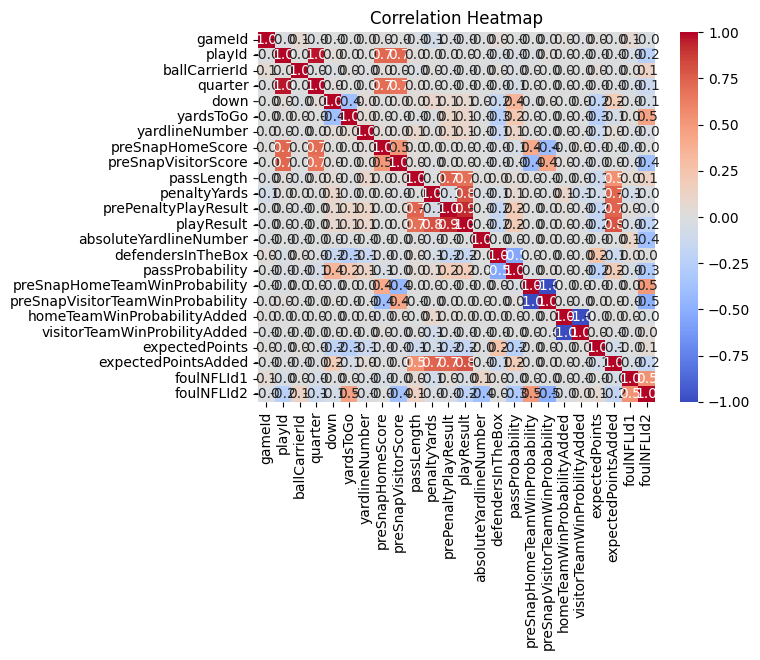

In [ ]:
# Sample DataFrame
# (Assuming you already have your DataFrame 'df' with numerical columns)

# Calculate the correlation matrix
correlation_matrix = plays_df.corr()
print(correlation_matrix)
# Create a heatmap to visualize the correlation matrix
# plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# encodings

# playDescription: Make a column for Touchdown or not touchdown
# gameClock + Quarter -> new column for minutes left in game
# foulName: 1,2,3,...



In [ ]:
# offensiveFormation: 1,2,3,... prob need it as one hot encoded not 1234
unique_values = plays_df['offenseFormation'].unique()

print(unique_values)
plays_df['offenseFormationEncoded'] = plays_df['offenseFormation'].map({'SHOTGUN':1, 'I_FORM':2, 'SINGLEBACK':3, 'EMPTY':4, 'PISTOL':5, 'WILDCAT':6, 'JUMBO':7, "nan":0})

['SHOTGUN' 'I_FORM' 'SINGLEBACK' 'EMPTY' 'PISTOL' 'WILDCAT' 'JUMBO' nan]


In [ ]:
# playNullifiedByPenalty: No = 0, 1 = Yes
plays_df['playNullifiedByPenaltyEncoded'] = plays_df['playNullifiedByPenalty'].map({'N': 0, 'Y': 1})

In [ ]:
# passResult: Encode blanks as a 0 for failed pass, encode C or R as 1 since the quarterback doesnt lose the ball
plays_df['passResult'] = plays_df['passResult'].fillna('H')
unique_values = plays_df['passResult'].unique()

print(unique_values)
plays_df['passResultEncoded'] = plays_df['passResult'].map({'H': 0, 'C': 1, 'R': 1})

['C' 'H' 'R']


In [ ]:
# touchdown encoded for play description
def contains_touchdown(s):
    return 'touchdown' in s.lower()

# Apply the function to the 'text' column and assign values to the new column 'isTouchdown'
plays_df['isTouchdown'] = plays_df['playDescription'].apply(contains_touchdown).astype(int)


# one hot encoded for formation & foulName
# one_hot_encoded = pd.get_dummies(plays_df['offenseFormation'], prefix='offenseFormation')
# plays_df = pd.concat([plays_df, one_hot_encoded], axis=1)

# one_hot_encoded = pd.get_dummies(plays_df['foulName1'], prefix='foulName1')
# plays_df = pd.concat([plays_df, one_hot_encoded], axis=1)


# minutes left encoded
minutesLeft = []
quarters = [0, 15, 30, 45]
for index, row in plays_df.iterrows():
    quarter = row['quarter']
    if quarter >=5:
        minutesLeft.append(0)
    else:
        gameClock = row['gameClock']
        minutes, seconds = map(int, gameClock.split(':'))
        timeElapsed = quarters[quarter-1] + minutes + (seconds/60)
        timeLeft = 60 - timeElapsed
        minutesLeft.append(timeLeft)

plays_df['minutesLeft'] = minutesLeft
plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,offenseFormationEncoded,playNullifiedByPenaltyEncoded,passResultEncoded,isTouchdown,minutesLeft
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.981955,NaN,NaN,NaN,NaN,1.0,0,1,0,7.133333
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,-0.263424,NaN,NaN,NaN,NaN,1.0,0,0,0,7.366667
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,1.133666,NaN,NaN,NaN,NaN,2.0,0,1,0,36.050000
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,-0.043580,NaN,NaN,NaN,NaN,3.0,0,0,0,16.800000
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,-0.167903,NaN,NaN,NaN,NaN,2.0,0,0,0,36.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12481,2022100204,123,43293,Ezekiel Elliott,(13:31) E.Elliott right tackle to WAS 38 for 1...,1,1,10,DAL,WAS,...,-0.504018,NaN,NaN,NaN,NaN,3.0,0,0,0,46.483333
12482,2022091200,3467,46189,Will Dissly,(6:08) G.Smith pass short right to W.Dissly to...,4,1,10,SEA,DEN,...,-0.444642,NaN,NaN,NaN,NaN,3.0,0,1,0,8.866667
12483,2022101605,3371,44860,Joe Mixon,(9:35) (Shotgun) J.Mixon left end to CIN 47 fo...,4,1,10,CIN,NO,...,0.203819,NaN,NaN,NaN,NaN,1.0,0,0,0,5.416667
12484,2022100207,2777,52449,Jonathan Taylor,(2:02) (Shotgun) J.Taylor up the middle to TEN...,3,1,10,IND,TEN,...,-0.976039,NaN,NaN,NaN,NaN,1.0,0,0,0,27.966667


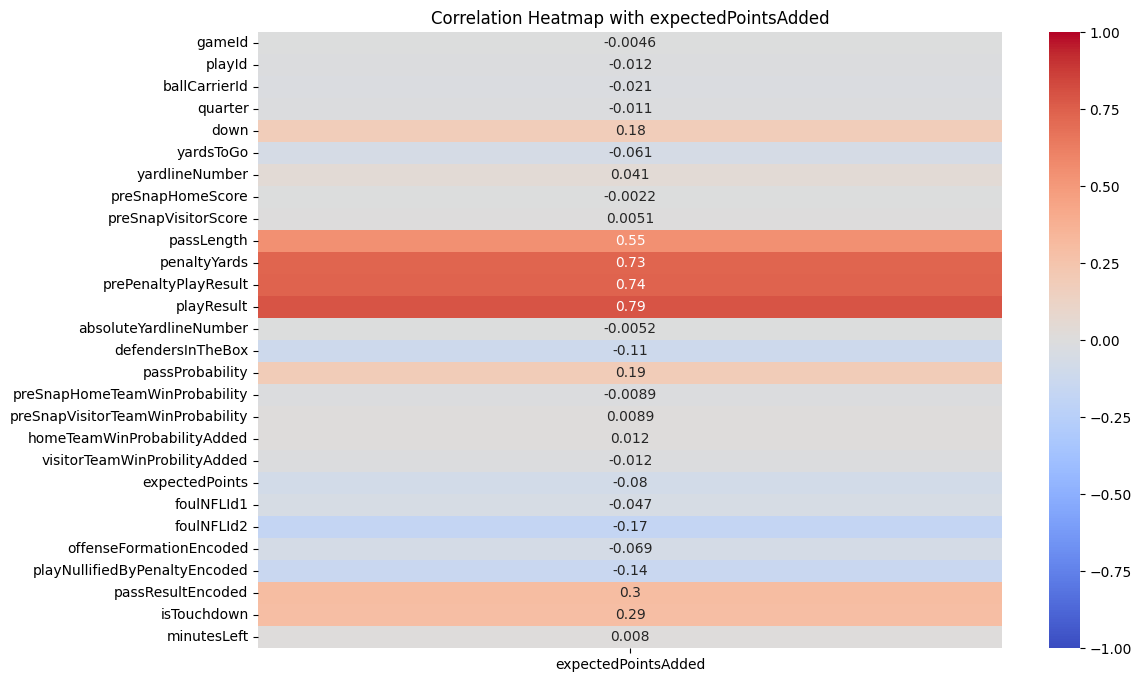

In [ ]:
# Replace 'target_column' with the actual name of the column you're interested in
target_column = 'expectedPointsAdded'

dfCorr = plays_df.corr()

# Apply filtering conditions to the correlation matrix
filteredDf = dfCorr[(dfCorr != 1.000)]

# Filter the correlation matrix to show only correlations with the target column
correlation_with_target = filteredDf[[target_column]].drop(target_column)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_with_target, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title(f'Correlation Heatmap with {target_column}')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Assuming 'data' is your dataset
df = plays_df[['offenseFormationEncoded', 'passLength', 'penaltyYards', 
'prePenaltyPlayResult', 'playResult', 'passResultEncoded', 'isTouchdown', 'down',"expectedPointsAdded"]]
df = df.fillna(0)



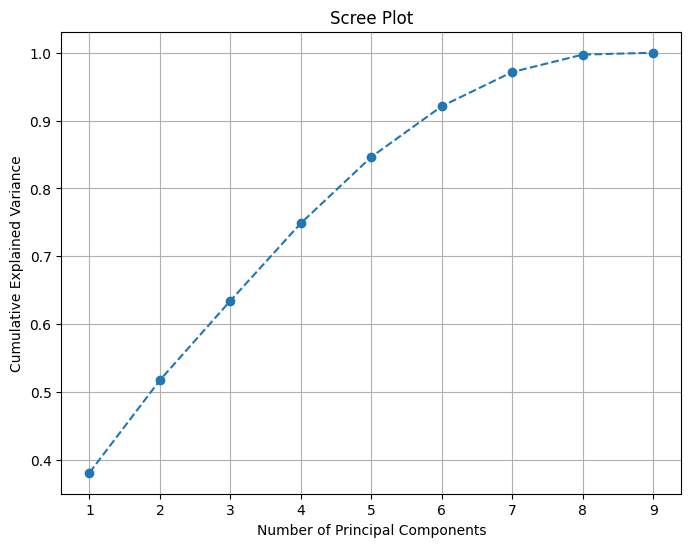

In [ ]:
# Step 2: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Step 3-5: Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
import plotly.express as px

features = ['offenseFormationEncoded', 'prePenaltyPlayResult', 'passLength', 'penaltyYards']

fig = px.scatter_matrix(
    df,
    dimensions=features,
    color="expectedPointsAdded"
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:


import plotly.express as px

features = ['playResult', 'passResultEncoded', 'isTouchdown', 'down']

fig = px.scatter_matrix(
    df,
    dimensions=features,
    color="expectedPointsAdded"
)
fig.update_traces(diagonal_visible=False)
fig.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



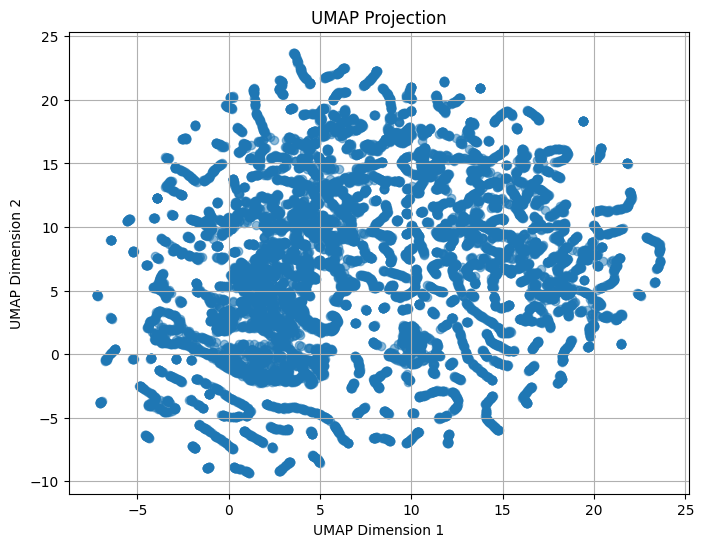

In [ ]:
from umap.umap_ import UMAP

# Assuming 'data' is your high-dimensional dataset
reducer = UMAP(n_neighbors=8, min_dist=0.3, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(df)


import matplotlib.pyplot as plt

# Scatter plot of UMAP results
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
plt.title('UMAP Projection')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()



In [ ]:
reducer = UMAP(random_state=42)
reducer.fit(df)

/root/venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

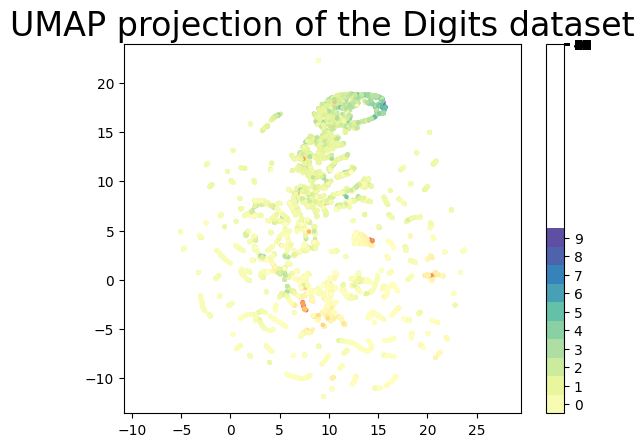

In [ ]:
embedding = reducer.transform(df)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

plt.scatter(embedding[:, 0], embedding[:, 1], c=df[target_column], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(100))
plt.title('UMAP projection of the Digits dataset', fontsize=24);

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



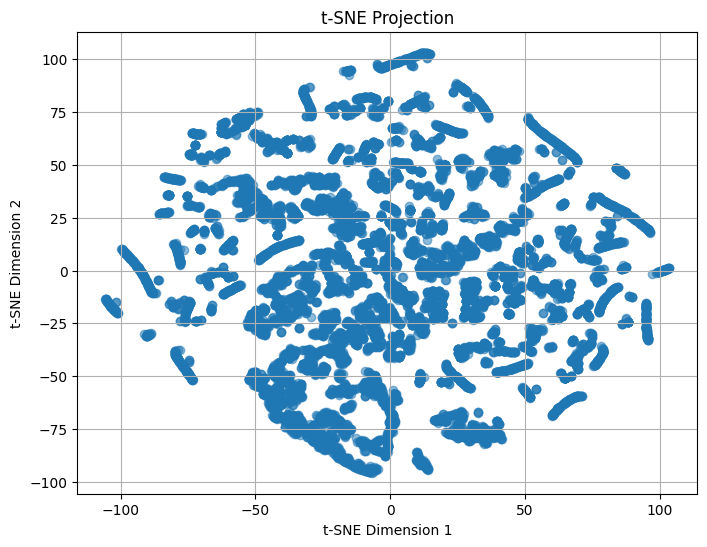

In [ ]:
from sklearn.manifold import TSNE

# Assuming 'data' is your high-dimensional dataset
tsne = TSNE(n_components=2, random_state=42)  # 2 components for visualization
embedding = tsne.fit_transform(df)
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.5)
plt.title('t-SNE Projection')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

In [ ]:
mainFeatures = ['passLength', 'penaltyYards', 'prePenaltyPlayResult', 'playResult', 'passResultEncoded', 'isTouchdown']
allVars = mainFeatures + ['expectedPointsAdded']
modelDataDf = plays_df[allVars]
correlations = {}

for column in modelDataDf:
    correlations[column] = modelDataDf.corr()[column]


correlation_df = pd.DataFrame(correlations)
# print(correlation_df)

# if you decide to add a feature please make sure it doesnt have any NAs expectedPointsAdded has 1 NA so ima just drop it
columns_to_fill = ['passLength', 'penaltyYards']

modelDataDf[columns_to_fill] = modelDataDf[columns_to_fill].fillna(0)
nan_count_by_column = modelDataDf.isnull().sum()
print(nan_count_by_column)
print(modelDataDf.shape)

correlation_df

passLength              0
penaltyYards            0
prePenaltyPlayResult    0
playResult              0
passResultEncoded       0
isTouchdown             0
expectedPointsAdded     1
dtype: int64
(12486, 7)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,passLength,penaltyYards,prePenaltyPlayResult,playResult,passResultEncoded,isTouchdown,expectedPointsAdded
passLength,1.000000,-0.005656,0.740759,0.684348,NaN,0.111029,0.545819
penaltyYards,-0.005656,1.000000,-0.061576,0.799153,0.100747,0.015373,0.733808
prePenaltyPlayResult,0.740759,-0.061576,1.000000,0.922083,0.346570,0.159097,0.737222
playResult,0.684348,0.799153,0.922083,1.000000,0.323724,0.136457,0.792695
passResultEncoded,NaN,0.100747,0.346570,0.323724,1.000000,-0.005945,0.299263
isTouchdown,0.111029,0.015373,0.159097,0.136457,-0.005945,1.000000,0.289789
expectedPointsAdded,0.545819,0.733808,0.737222,0.792695,0.299263,0.289789,1.000000


In [ ]:
# I've split the data lmk if yall have any changes you suggest
# make sure to make your code easily changeable especially if we decide we wanna add another feature 
# try to write most of your code in terms of the modelDataset that way any changes can be easily worked into the models

modelDataDf = modelDataDf.dropna()

X = modelDataDf[mainFeatures]
y = modelDataDf['expectedPointsAdded']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# for people that dont need validation use these 
combined_X = np.vstack((X_train, X_val))
combined_y = np.concatenate((y_train, y_val))
print(len(combined_X))
print(len(combined_y))

11236
11236


In [ ]:
# Linear -Mr. Skywalker
lr = Linear()
# Fit the model on the entire training data
lr.fit(combined_X, combined_y)
# Predicting the Test set results
y_pred = lr.predict(X_test)
# Calculate and print mse 
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of Linear: {mse}")

Mean Squared Error of Linear: 0.5189650114086612
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



degree:  1
degree:  2
degree:  3
degree:  4
degree:  5
degree:  6
degree:  7
Optimal Polynomial Degree: 1


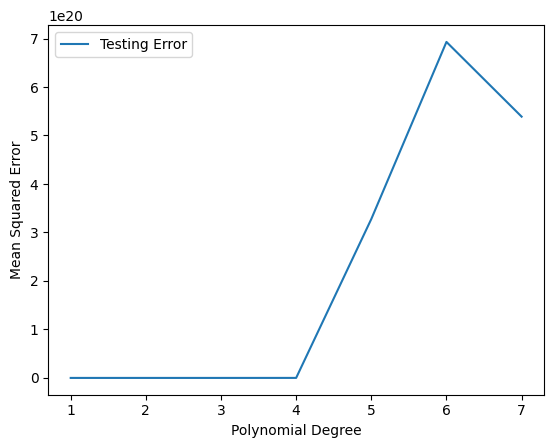

MSE:  0.52431933377496


In [ ]:
# Polynomial Regression

#Convert to Numpy
X_train_log = copy.deepcopy(combined_X)
X_test_log = X_test.to_numpy()
y_train_log = copy.deepcopy(combined_y)
y_test_log = y_test.to_numpy()

# Scale Training Data
train_scaler = StandardScaler()
test_scaler = StandardScaler()
X_train_scaled_log = train_scaler.fit_transform(X_train_log)
X_test_scaled_log = test_scaler.fit_transform(X_test_log)

max_degree = 7  # Maximum degree to test
test_errors = []

for degree in range(1, max_degree + 1):
    # Create polynomial features
    print("degree: ", degree)
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_scaled_log)
    X_test_poly = poly_features.transform(X_test_scaled_log)

    # Fit the model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train_log)

    # Predict and calculate the error
    test_pred = poly_model.predict(X_test_poly)
    test_errors.append(mean_squared_error(y_test, test_pred))

# Find the degree with the lowest test error
optimal_degree = np.argmin(test_errors) + 1
print(f"Optimal Polynomial Degree: {optimal_degree}")

plt.plot(range(1, max_degree + 1), test_errors, label='Testing Error')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Training optimal model
poly_features = PolynomialFeatures(degree=optimal_degree)
X_train_poly = poly_features.fit_transform(X_train_scaled_log)
X_test_poly = poly_features.transform(X_test_scaled_log)

# Fit the model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_log)

# Predict and calculate the error
test_pred = poly_model.predict(X_test_poly)
mse = mean_squared_error(y_test, test_pred)
print("MSE: ", mse)

In [ ]:
# Support Vector Regression- Mr. Skywalker 
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
#make pipeline
SVRR = make_pipeline(train_scaler, SVR())
# Fit the model on the entire training data
SVRR.fit(combined_X, combined_y)
# Predicting the Test set results
y_pred = SVRR.predict(X_test)
# Calculate and print mse 
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of the svr: {mse}")

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

Mean Squared Error of the svr: 0.45221694125900297


In [ ]:
# NN -Khush

def create_model(layers, neurons, activation):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        else:
            model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))  # Output layer

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create KerasRegressor wrapper for use in GridSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'layers': [1, 2, 3],  # Number of hidden layers
    'neurons': [8, 16, 32, 64, 75],  # Neurons in each layer
    'activation': ['relu', 'tanh', 'sigmoid']  # Activation functions
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the grid search
grid_result = grid.fit(X, y, validation_data=(X_val, y_val))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/tmp/ipykernel_112/285343369.py:16: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.

2023-11-29 19:30:53.886068: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-29 19:30:53.886103: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-29 19:30:53.886124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-003d38e4-eba7-48b7-b7d1-28e88cc6de1f): /proc/driver/nvidia/version does not exist
2023-11-29 19:30:53.886335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instr

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

params_list = grid_result.cv_results_['params']
minMse = 80000000
minParams = None
for params in params_list:
    # Create a new model with the specified parameters
    model = KerasRegressor(build_fn=create_model, **params, verbose=0)
    
    # Fit the model on the entire training data
    model.fit(X_train, y_train)
    
    # Evaluate the model on the test data
    test_predictions = model.predict(X_test)
    
    # Calculate and print mse and compare with the min so far
    mse = mean_squared_error(y_test, test_predictions)
    if mse < minMse:
        minMse = mse
        minParams = params

    if grid_result.best_params_ == params:
        print('Params of the best model suggested by grid search: ', params)
        print('MSE on the model suggested by grid search: ', mse)

print('Min MSE: ', minMse)
print('Min Params: ', minParams)

Params of the best model suggested by grid search:  {'activation': 'relu', 'layers': 2, 'neurons': 75}
MSE on the model suggested by grid search:  0.47130455866151955
Min MSE:  0.46613392278062377
Min Params:  {'activation': 'tanh', 'layers': 2, 'neurons': 75}


In [ ]:
# Decision Tree Kush

tree_regressor = DecisionTreeRegressor(random_state=42)

# Train the Decision Tree regressor
tree_regressor.fit(combined_X, combined_y)

# Predict on the test set
y_pred = tree_regressor.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of the Decision Tree Regressor: {mse}")


Mean Squared Error of the Decision Tree Regressor: 0.4423627342875162
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names



In [ ]:
# Random Forest -Up for grabs (Zaid)
from sklearn.ensemble import RandomForestRegressor  # For regression

# For regression
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(combined_X, combined_y)

# Predicting the Test set results
y_pred = model.predict(X_test)

# Evaluate the model (for classification)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")


MSE: 0.40628551515596406
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=003d38e4-eba7-48b7-b7d1-28e88cc6de1f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>